In [1]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

/home/h4rry/anaconda3/envs/cudaEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGBA")

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            #mask = torch.argmax(mask, dim=-1)
            #mask = torch.tensor(np.array(mask), dtype=torch.long)  # Long tensor for class labels
        
        return image, mask

In [3]:
from torchvision import transforms

# Eğitim ve test dönüşümleri
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Görüntü boyutlandırma
    transforms.ToTensor()
])

In [4]:
train_dataset = SegmentationDataset("road/train/image/", "road/train/label/", transform=transform)
test_dataset = SegmentationDataset("road/test/images/", "road/test/labels/", transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [6]:
image = Image.open("road/test/labels/21.png")
print(image.mode)

RGBA


In [5]:

dataiter = iter(train_loader)
images, masks = next(dataiter)
#images = images.permute(0, 2, 1, 3)

# Görüntülerin ve maskelerin boyutlarını yazdır
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

Images shape: torch.Size([8, 3, 256, 256])
Masks shape: torch.Size([8, 4, 256, 256])


In [5]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = nn.Sequential(CBR(3, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.enc4 = nn.Sequential(CBR(256, 512), CBR(512, 512))
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(CBR(512, 1024), CBR(1024, 1024))
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(CBR(1024, 512), CBR(512, 512))
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(CBR(512, 256), CBR(256, 256))
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 128))
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))
        
        # Output layer
        self.conv_last = nn.Conv2d(64, 4, kernel_size=1, ) # 4 = Class number

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((enc4, dec4), dim=1)
        dec4 = self.dec4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((enc3, dec3), dim=1)
        dec3 = self.dec3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((enc2, dec2), dim=1)
        dec2 = self.dec2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((enc1, dec1), dim=1)
        dec1 = self.dec1(dec1)
        
        return self.conv_last(dec1)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [7]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [8]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            
            all_preds.append(preds)
            all_labels.append(masks.cpu().numpy())
    
    return np.concatenate(all_preds), np.concatenate(all_labels)

In [9]:
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

# Modeli test edin
preds, labels = evaluate_model(model, test_loader, device)

Epoch 1/30, Loss: 3.8757
Epoch 2/30, Loss: 3.7671
Epoch 3/30, Loss: 3.7146
Epoch 4/30, Loss: 3.6770
Epoch 5/30, Loss: 3.6508
Epoch 6/30, Loss: 3.6307
Epoch 7/30, Loss: 3.6151
Epoch 8/30, Loss: 3.6019
Epoch 9/30, Loss: 3.5922
Epoch 10/30, Loss: 3.5841
Epoch 11/30, Loss: 3.5778
Epoch 12/30, Loss: 3.5732
Epoch 13/30, Loss: 3.5688
Epoch 14/30, Loss: 3.5651
Epoch 15/30, Loss: 3.5624
Epoch 16/30, Loss: 3.5599
Epoch 17/30, Loss: 3.5576
Epoch 18/30, Loss: 3.5557
Epoch 19/30, Loss: 3.5534
Epoch 20/30, Loss: 3.5530
Epoch 21/30, Loss: 3.5515
Epoch 22/30, Loss: 3.5505
Epoch 23/30, Loss: 3.5484
Epoch 24/30, Loss: 3.5479
Epoch 25/30, Loss: 3.5467
Epoch 26/30, Loss: 3.5458
Epoch 27/30, Loss: 3.5461
Epoch 28/30, Loss: 3.5446
Epoch 29/30, Loss: 3.5448
Epoch 30/30, Loss: 3.5434


In [10]:
def calculate_iou_scikit(true_mask, pred_mask):
    # Maskeleri düzleştirip 1D hale getirme işlemi
    true_mask = true_mask.flatten()
    pred_mask = pred_mask.flatten()
    
    # IoU'yu hesaplama (Jaccard Score)
    iou_score = jaccard_score(true_mask, pred_mask, average ='micro') # Değişiklik denenecek.
    return iou_score

In [12]:
def calculate_iou(true_mask, pred_mask):
    iou_scores = []
    
    # Her bir sınıf için IoU hesapla
    for class_id in range(true_mask.shape[0]):
        true_class_mask = (true_mask == class_id).float()
        pred_class_mask = (pred_mask == class_id).float()
        
        intersection = torch.logical_and(true_class_mask, pred_class_mask).sum()
        union = torch.logical_or(true_class_mask, pred_class_mask).sum()
        
        iou_score = intersection / (union + 1e-6)  
        iou_scores.append(iou_score.item())
    
    return iou_scores

In [15]:
# data_iter = iter(test_loader)
# images, masks = next(data_iter)

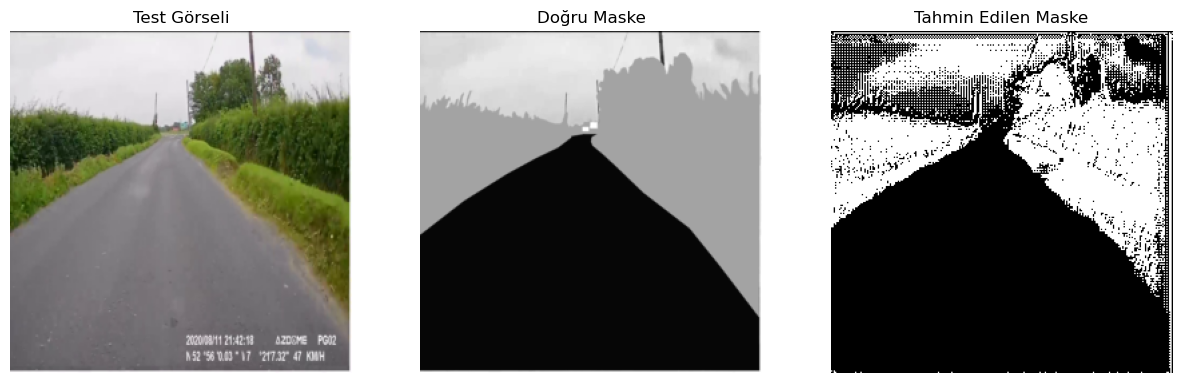

IoU Skorları:  0.4082462787628174


In [13]:
# Test veri setinden rastgele bir örnek seçip görselleştirme

model.eval()  # Modeli değerlendirme moduna al

with torch.no_grad():  # Geriye yayılım yapmayacağımız için no_grad

    images, masks = next(iter(test_loader))  # Test loader'dan bir batch al

    images = images.to(device)
    masks = masks.to(device)

    # Modelin tahminini al
    outputs = model(images)

    image = images[5].cpu().numpy().transpose(1, 2, 0)  # Görseli (3, 256, 256) -> (256, 256, 3) yap
    # Gerçek maskeyi ve tahminleri seç
    true_mask = masks[5].cpu()  # Gerçek maskeyi (4, 256, 256) yap
    predicted_mask = torch.sigmoid(outputs[5]).cpu()  # Tahmin edilen maskeyi (4, 256, 256) yap

    # Binary maskeler oluştur
    predicted_mask = (predicted_mask > 0.5).float()  # Binary maskeler oluştur

    # IoU hesaplayalım
    iou_scores = calculate_iou(true_mask, predicted_mask)

    # Görselleştirme
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Görseli göster
    ax[0].imshow(image)
    ax[0].set_title("Test Görseli")
    ax[0].axis('off')

    # Gerçek maskeyi göster (bir örnek sınıf)
    ax[1].imshow(true_mask[0].cpu().numpy(), cmap='gray')  # 1. sınıf maskesi
    ax[1].set_title("Doğru Maske")
    ax[1].axis('off')

    # Tahmin edilen maskeyi göster (bir örnek sınıf)
    ax[2].imshow(predicted_mask[0].cpu().numpy(), cmap='gray')  # 1. sınıf maskesi
    ax[2].set_title(f"Tahmin Edilen Maske")
    ax[2].axis('off')

    plt.show()

    print("IoU Skorları: ", iou_scores[1])

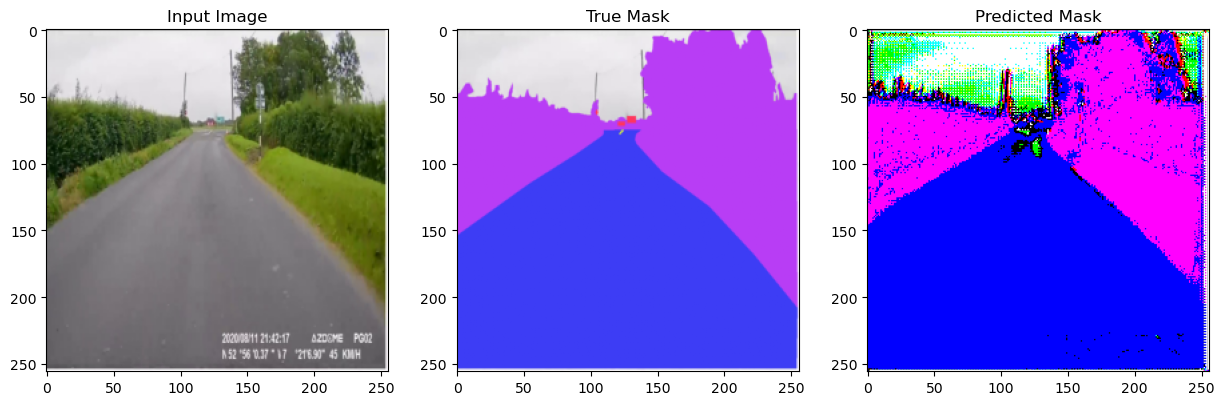

In [15]:
# Test veri setinden rastgele bir örnek seçip görselleştirme
model.eval()  # Modeli değerlendirme moduna al

with torch.no_grad():  # Geriye yayılım yapmayacağımız için no_grad
    images, masks = next(iter(test_loader))  # Test loader'dan bir batch al

    images = images.to(device)
    masks = masks.to(device)

    # Modelin tahminini al
    outputs = model(images)

    # Sadece ilk görüntüyü görselleştirelim
    image = images[2].cpu().permute(1, 2, 0).numpy()  # Görüntüyü HWC formatına çevir
    true_mask = masks[2].cpu().permute(1, 2, 0).numpy()  # Gerçek maskeyi (1, 256, 256) -> (256, 256) yap
    
    predicted_mask = torch.sigmoid(outputs[2]).cpu().permute(1, 2, 0)  # Tahmin edilen maskeyi (256, 256) yap
    predicted_mask = (predicted_mask > 0.5).float() # Bu satır açıldığında renkler True Mask görüntüsüne yaklaşıyor.

    # Görüntüleme
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')

    ax[1].imshow(true_mask, cmap='gray')
    ax[1].set_title('True Mask')

    ax[2].imshow(predicted_mask, cmap='gray')
    ax[2].set_title(f'Predicted Mask')

    plt.show()

In [28]:
torch.save(model,"UnetManuelModel.pth")
torch.save(model.state_dict(),"UnetManuel_Weights.pth")

In [19]:
# Modeli oluşturun
def get_model(num_classes):
    preModel = smp.Unet(
        encoder_name="resnet34",  # Encoder model olarak ResNet34 kullanıldı
        #encoder_weights="imagenet",  # Önceden eğitilmiş ağırlıklar kullanılabilir.
        in_channels=3,  # Giriş kanalları, RGB görüntüler için 3
        classes=num_classes,  # Sınıf sayısı
    )
    return model

In [24]:
# Modeli oluşturun
num_classes = 3 # Binary segmentation için 1 sınıf
premodel = get_model(num_classes=num_classes)

In [25]:
import torch.optim as optim
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, kayıp fonksiyonu ve optimizasyon yöntemi
premodel = get_model(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # Çoklu sınıflı segmentasyon için
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [26]:
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = train_model(premodel, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

# Modeli test eetme işlemi
preds, labels = evaluate_model(premodel, test_loader, device)

Epoch 1/30, Loss: 4.4228
Epoch 2/30, Loss: 4.2034
Epoch 3/30, Loss: 4.1521
Epoch 4/30, Loss: 4.0583
Epoch 5/30, Loss: 3.9936
Epoch 6/30, Loss: 3.9456
Epoch 7/30, Loss: 3.8980
Epoch 8/30, Loss: 3.8609
Epoch 9/30, Loss: 3.8495
Epoch 10/30, Loss: 3.8112
Epoch 11/30, Loss: 3.7912
Epoch 12/30, Loss: 3.7801
Epoch 13/30, Loss: 3.7545
Epoch 14/30, Loss: 3.7382
Epoch 15/30, Loss: 3.7241
Epoch 16/30, Loss: 3.7107
Epoch 17/30, Loss: 3.6979
Epoch 18/30, Loss: 3.6853
Epoch 19/30, Loss: 3.6819
Epoch 20/30, Loss: 3.6662
Epoch 21/30, Loss: 3.6600
Epoch 22/30, Loss: 3.6539
Epoch 23/30, Loss: 3.6492
Epoch 24/30, Loss: 3.6405
Epoch 25/30, Loss: 3.6353
Epoch 26/30, Loss: 3.6303
Epoch 27/30, Loss: 3.6243
Epoch 28/30, Loss: 3.6206
Epoch 29/30, Loss: 3.6169
Epoch 30/30, Loss: 3.6126


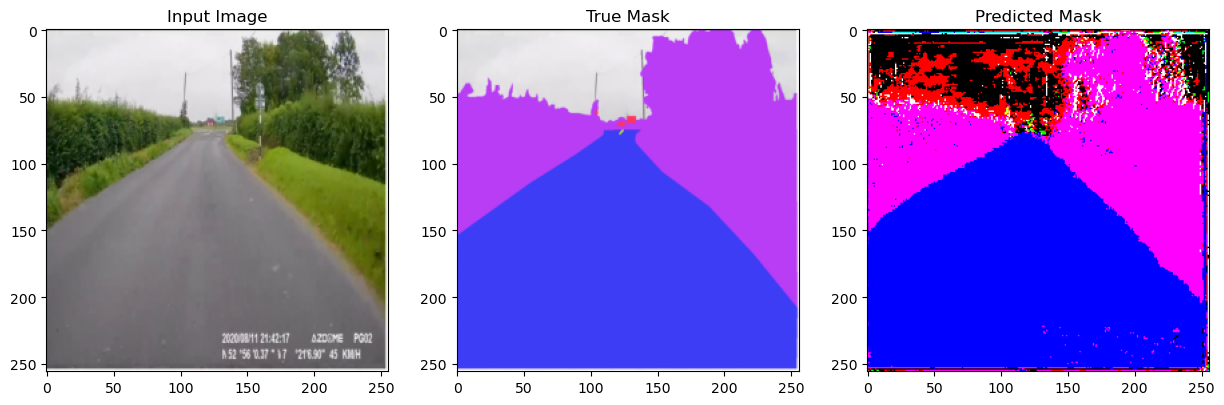

In [27]:
# Test veri setinden rastgele bir örnek seçip görselleştirme
model.eval()  # Modeli değerlendirme moduna al

with torch.no_grad():  # Geriye yayılım yapmayacağımız için no_grad
    images, masks = next(iter(test_loader))  # Test loader'dan bir batch al

    images = images.to(device)
    masks = masks.to(device)

    # Modelin tahminini al
    outputs = premodel(images)

    # Sadece ilk görüntüyü görselleştirelim
    image = images[2].cpu().permute(1, 2, 0).numpy()  # Görüntüyü HWC formatına çevir
    true_mask = masks[2].cpu().permute(1, 2, 0).numpy()  # Gerçek maskeyi (1, 256, 256) -> (256, 256) yap
    
    predicted_mask = torch.sigmoid(outputs[2]).cpu().permute(1, 2, 0)  # Tahmin edilen maskeyi (256, 256) yap
    predicted_mask = (predicted_mask > 0.5).float() # Bu satır açıldığında renkler True Mask görüntüsüne yaklaşıyor.

    # Görüntüleme
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')

    ax[1].imshow(true_mask, cmap='gray')
    ax[1].set_title('True Mask')

    ax[2].imshow(predicted_mask, cmap='gray')
    ax[2].set_title(f'Predicted Mask')

    plt.show()

In [29]:
torch.save(premodel,"UnetPreTrainedModel.pth")
torch.save(premodel.state_dict(),"UnetPretrained_Weights.pth")

## Sonuç olarak görselleştirme sonuçlarından anlaşıldığı üzere manuel model kullanıldığında model tahmini daha güçlü (Şuan).